In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import json

from konlpy.tag import Hannanum
from konlpy.tag import Kkma
from konlpy.tag import Okt
from konlpy.tag import Mecab
from PIL import Image
from wordcloud import ImageColorGenerator
from dateutil.relativedelta import relativedelta
from config import *




In [2]:
from wordcloud import WordCloud
from collections import Counter

## 함수화

### Fianl_Organization_Module에 정의 해놓은 함수

In [5]:
def fetch_news_docs_keyword(date_from, date_to, page, keyword):
    
    date_from = date_from.isoformat()[0:10]
    date_to = date_to.isoformat()[0:10]

    query = {
        "query": {
            "bool": {
                "must":[
                    {
                        "match":{
                            "body": keyword
                        }
                    },
                    {
                    "range":{
                        "created_at": {
                            "gte": date_from,
                            "lt": date_to
                            }
                        }
                    }
                ]
            },
        },
        "size": 10,
        "from": page * 10
    }

    headers = {
        'Content-Type': 'application/json'
    }

    resp = requests.get(
        f'{ELASTIC_SEARCH_URL}/news/_search',
        headers = headers,
        data = json.dumps(query),
        auth = ELASTIC_SEARCH_AUTH
    )

    assert resp.status_code == 200

    data = json.loads(resp.text)
    hits = data['hits']['hits']

    return hits

def get_bodies(hits):

    return hits['_source']['body']


In [6]:
def get_titles(hits):

    return hits['_source']['title']


In [7]:
def download_total_title_keyword (date_from, date_to, keyword):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    print("Downloading data from OpenSearch server")

    total_title_list = []

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(f"{str_date} Start!")

        daily_title_list = []

        start_date = date_interval[i]
        end_date = date_interval[i] + relativedelta(days=1)

        for page in range(1000):

#            print('.', end='', flush=True)

            hits = fetch_news_docs_keyword(start_date, end_date, page, keyword)

            if len(hits) == 0:
                break

            for doc in hits:
            
                daily_title_list.append(get_titles(doc))

        total_title_list.append(daily_title_list)

        print("***" + str_date + "End!" + "***")

    print("Daily Data end!")

    return total_title_list


In [16]:
def preprocess(date_from, date_to, keyword_list):
    
    buffer = []

    for keyword in keyword_list:
        key = download_total_title_keyword (date_from, date_to, keyword)
        key = sum(key,[])
        

        key=' '.join(s for s in key)
        buffer.append(key)
    
    
    
    return buffer 

In [18]:
buffer = preprocess('2022-05-17','2022-05-17',['삼성전자','하이닉스'])
len(buffer)

2022-05-17 Start!
***2022-05-17End!***
Daily Data end!
2022-05-17 Start!
***2022-05-17End!***
Daily Data end!


2

### 위의 함수에 전처리 하여 각 종목들의 기사body들로 이루어진 리스트들의 리스트를 넘겨주면 portfolio 내 비중에 비례하여 빈도수 처리하여 워드클라우드 생성

In [11]:
def plot_wordcloud(bodies,weight,score):
    '''
    각 종목들의 기사 body들과 포트폴리오 가중치를 인수로 받아 
    가중치만큼 반영하여 빈도수에 가중하여 워드클라우드로 출력
    '''


    weight = np.array(weight)*100
    np.rint(weight)
    buffer=[]
    
    for i,v in enumerate(bodies):
        okt = Okt()
        noun_list = list(okt.nouns(v))
        pos_list = list(okt.pos(v))
        noun_list=[x for x in noun_list if len(x)>1]

        noun_list*= int(weight[i])

        buffer.append(noun_list)
        
    buffer = sum(buffer,[]) # 리스트의 리스트를 하나의 리스트로 전환
        

    dancing_mask = np.array(Image.open('psy2.jpg').convert("RGBA"))
    sunny_mask = np.array(Image.open('sunny.jpg').convert("RGBA"))
    sunny_cloudy_mask = np.array(Image.open('sunny_clouds.jpg').convert("RGBA"))
    cloudy_mask = np.array(Image.open('cloud2.png').convert("RGBA"))
    rainy_mask = np.array(Image.open('raindrop.png').convert("RGBA"))

    if score >= 0.9:
        mask = dancing_mask
        
    elif score >= 0.75:
        mask = sunny_mask
        
    elif score >= 0.5:
        mask = sunny_cloudy_mask
        
    elif score >= 0.25:
        mask = cloudy_mask
        
    else :
        mask = rainy_mask
        

    wordcloud = WordCloud(font_path='HANYheadM',mask=mask,width=800, height=800,background_color='white', color_func=ImageColorGenerator(mask))

    count = Counter(buffer)
    wordcloud = wordcloud.generate_from_frequencies(count)
    array = wordcloud.to_array()

    fig = plt.figure(figsize=(10,10))
    plt.imshow(array, interpolation='bilinear')
    plt.show()

    return

In [12]:
body1 = body
body2 = """마이애미 비트코인 콘퍼런스 행사에 맞춰 동상 공개
마이애미 비트코인 콘퍼런스 행사에서 제막한 비트코인 황소상[로이터 연합뉴스 자료사진. 재판매 및 DB 금지](로스앤젤레스=연합뉴스) 정윤섭 특파원 = 미국 플로리다주 마이애미에 뉴욕 월가의 '돌진하는 황소상'을 본뜬 비트코인 황소상이 세워졌다.    블룸버그통신은 6일(현지시간) 마이애미가 '비트코인 2022 콘퍼런스' 행사를 시작하면서 개막 이벤트로 이 황소상을 세웠다고 보도했다.    '마이애미 불'로 명명된 무게 3천 파운드(1.36t)짜리 이 동상은 레이저 눈을 가진 로봇 황소 모양으로 제작됐다.    레이저 눈은 비트코인 업계에서 가격 상승을 의미하는 뜻으로 사용된다.    뉴욕 월가의 돌진하는 황소상이 상승장을 상징하는 것과 같은 맥락이다.    비트코인 황소상은 플로리다주에 본사를 둔 가상화폐 거래 플랫폼 트레이드스테이션 의뢰로 제작됐다.    프랜시스 수아레스 마이애미 시장은 황소상 제막식에서 "금융의 미래는 마이애미에 있다"고 말했다.    마이애미는 가상화폐 중심 도시를 표방하면서 관련 기업 유치와 블록체인 산업 육성에 적극적으로 나서고 있다.
비트코인 콘퍼런스 행사에 참석한 억만장자 투자자 마이크 노보그라츠[로이터 연합뉴스 자료사진. 재판매 및 DB 금지]비트코인 가격은 황소상 제막과 상관없이 약세를 보이며 4만3천 달러대로 내려왔다.    미국 중앙은행인 연방준비제도(Fed·연준)의 통화 긴축 예고 등으로 기술주 중심의 나스닥 시장이 흔들렸고 비트코인도 동반 하락했다.    가상화폐 정보 사이트 코인데스크에 따르면 미국 서부 시간 기준 낮 12시 현재 비트코인 가격은 24시간 전과 비교해 4.60% 하락한 4만3천811달러를 기록했다.    하지만, 억만장자 가상화폐 투자자인 마이크 노보그라츠 갤럭시디지털 최고경영자(CEO)는 마이애미 비트코인 콘퍼런스에서 연준의 금리 인상 변수가 사라지면 비트코인이 가격이 오를 것이라고 주장했다.    그는 연준이 물가상승 압력 때문에 금리를 인상하겠지만, 향후 경기가 둔화하고 연준이 한발 물러서면 "비트코인은 달에 간다"고 말했다.    '달에 간다'(go to the moon)는 비트코인 급등을 예상할 때 사용하는 말이다.    마이애미 비트코인 콘퍼런스는 9일까지 진행되며 주최 측은 가상화폐 업계 관계자와 투자자 등 2만5천여 명이 참석할 것으로 예상했다.    jamin74@yna.co.kr"""

In [30]:

weight = [0.3,0.7]
score = 0.8

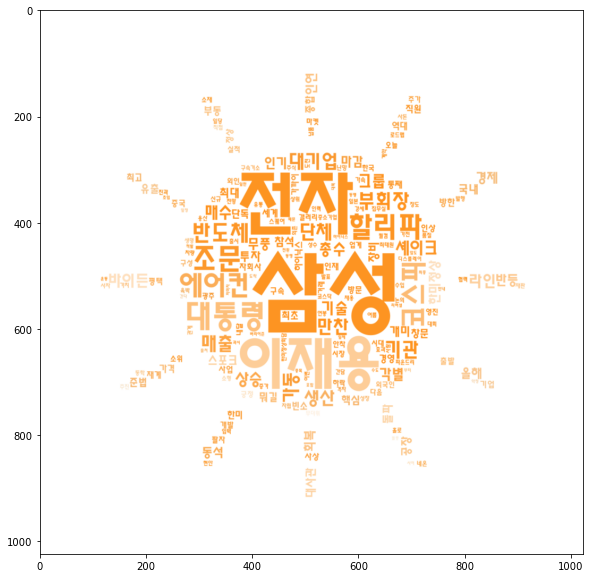

In [31]:
plot_wordcloud(buffer,weight,score)